In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import ADASYN


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTENC
import tensorflow as tf
from tensorflow.keras import layers, models, Input

In [ ]:
import tensorflow.keras.backend as K # Import keras backend

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        # K = keras.backend  # Define K here using keras.backend - No need for this line now
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - \
               K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed


In [ ]:
# === Load and preprocess data ==
df = pd.read_csv("carclaims.csv")
df["FraudFound"] = df["FraudFound"].map({"Yes": 1, "No": 0})
df.drop(columns=["PolicyNumber", "RepNumber", "Year"], inplace=True)

X = df.drop(columns=["FraudFound"])
y = df["FraudFound"]

In [ ]:
# Identify column types
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Define encoding strategies
one_hot_cols = [
    "Month", "MonthClaimed", "DayOfWeek", "DayOfWeekClaimed", "Sex", "MaritalStatus",
    "AccidentArea", "Fault", "PolicyType", "VehicleCategory", "PoliceReportFiled",
    "WitnessPresent", "AgentType", "BasePolicy"
]

ordinal_cols = [
    "VehiclePrice", "Days:Policy-Accident", "Days:Policy-Claim", "PastNumberOfClaims",
    "AgeOfVehicle", "AgeOfPolicyHolder", "NumberOfSuppliments", "AddressChange-Claim", "NumberOfCars"
]

embedding_col = ["Make"]

In [ ]:
print(tabulate(X.head(), headers='keys', tablefmt='fancy_grid'))

╒════╤═════════╤═══════════════╤═════════════╤════════╤════════════════╤════════════════════╤════════════════╤══════════════════════╤════════╤═════════════════╤═══════╤═══════════════╤═══════════════════╤═══════════════════╤══════════════════╤══════════════╤════════════════╤════════════════════════╤═════════════════════╤══════════════════════╤════════════════╤═════════════════════╤═════════════════════╤══════════════════╤═════════════╤═══════════════════════╤═══════════════════════╤════════════════╤══════════════╕
│    │ Month   │   WeekOfMonth │ DayOfWeek   │ Make   │ AccidentArea   │ DayOfWeekClaimed   │ MonthClaimed   │   WeekOfMonthClaimed │ Sex    │ MaritalStatus   │   Age │ Fault         │ PolicyType        │ VehicleCategory   │ VehiclePrice     │   Deductible │   DriverRating │ Days:Policy-Accident   │ Days:Policy-Claim   │ PastNumberOfClaims   │ AgeOfVehicle   │ AgeOfPolicyHolder   │ PoliceReportFiled   │ WitnessPresent   │ AgentType   │ NumberOfSuppliments   │ AddressChange-Cl

In [ ]:
print("ordinal_cols")
print(ordinal_cols, len(ordinal_cols))
print("one_hot_cols")
print(one_hot_cols,len(one_hot_cols))
print("numeric_cols")
print(numeric_cols,len(numeric_cols))

ordinal_cols
['VehiclePrice', 'Days:Policy-Accident', 'Days:Policy-Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'NumberOfSuppliments', 'AddressChange-Claim', 'NumberOfCars'] 9
one_hot_cols
['Month', 'MonthClaimed', 'DayOfWeek', 'DayOfWeekClaimed', 'Sex', 'MaritalStatus', 'AccidentArea', 'Fault', 'PolicyType', 'VehicleCategory', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'BasePolicy'] 14
numeric_cols
['WeekOfMonth', 'WeekOfMonthClaimed', 'Age', 'Deductible', 'DriverRating'] 5


In [ ]:
print(df.columns[df.isna().any()].tolist())

[]


In [ ]:

print(df['NumberOfCars'].unique())


['3 to 4' '1 vehicle' '2 vehicles' '5 to 8' 'more than 8']


In [ ]:
categorical_cols_cleaned = list(set(one_hot_cols + ordinal_cols + embedding_col))
remaining_cols = [col for col in X.columns if col not in categorical_cols_cleaned]
final_numeric_cols = [col for col in remaining_cols if col in numeric_cols]

# Map 'Make' to integer indices for embedding
make_vocab = X["Make"].astype("category").cat.categories.tolist()
make_to_idx = {cat: i for i, cat in enumerate(make_vocab)}
X["Make_encoded"] = X["Make"].map(make_to_idx)

# Save embedding inputs
make_input = X["Make_encoded"].values
X = X.drop(columns=["Make"])

# ---------------------------
# 2. Preprocessing Pipelines
# ---------------------------

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

one_hot_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

ordinal_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, final_numeric_cols),
    ("onehot", one_hot_transformer, one_hot_cols),
    ("ordinal", ordinal_transformer, ordinal_cols)
])

In [ ]:

# ---------------------------
# 3. Train/Test Split & Oversampling
# ---------------------------

X_train, X_test, y_train, y_test, make_train, make_test = train_test_split(
    X, y, make_input, test_size=0.2, stratify=y, random_state=42
)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)


In [ ]:
print(tabulate(X_train_proc[:5]))

---------  ---------  ----------  --------  --------  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 0.164069   0.238005  -1.24981    -0.17736   1.34855  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  1  0  0  1  0  1  0  1  0  0  0  0  0  0  0  1  0  0  0  1  1  0  1  0  0  1  0  0  3  2  1  4  3  2  3  0
 0.164069   0.238005  -0.434568   -0.17736  -1.33204  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0  1  0  0  0  1  0  1  0  0  1  0  0  0  0  0  0  0  1  0  1  0  1  0  1  0  0  0  1  0  3  2  2  4  4  1  3  0
-0.615874  -0.559179   0.380677   -0.17736   1.34855  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0

In [ ]:
# Calculate the total number of features after preprocessing
num_features_after_preprocessing = X_train_proc.shape[1]

# Create a boolean mask indicating categorical features
cat_feature_indices = [
    i
    for i, col in enumerate(X_train.columns)
    if col in one_hot_cols + ordinal_cols
]

# Create a boolean mask for SMOTENC
categorical_features_bool = [False] * num_features_after_preprocessing

# Update the mask to True for categorical features
for index in cat_feature_indices:
    try:
        categorical_features_bool[index] = True
    except IndexError:
        # Handle potential mismatch if cat_feature_indices are incorrect
        print(f"IndexError: Index {index} is out of bounds for the preprocessed data.")
        break

In [ ]:
# Apply ADASYN to numeric+encoded inputs only
print("Class distribution before ADASYN:")
print(y_train.value_counts(normalize=True))
adasyn = ADASYN(random_state=42)
X_train_res, y_train_res = adasyn.fit_resample(X_train_proc, y_train)

# Calculate the oversampling ratio
oversampling_ratio = len(y_train_res) / len(y_train)

# Repeat make_train based on the ratio, ensuring the length matches y_train_res
make_train_res = np.repeat(make_train, repeats=int(oversampling_ratio))

# Adjust the length of make_train_res if necessary to match y_train_res
make_train_res = make_train_res[:len(y_train_res)]
print("Class distribution after ADASYN:")
print(pd.Series(y_train_res).value_counts(normalize=True))

Class distribution before ADASYN:
FraudFound
0    0.940175
1    0.059825
Name: proportion, dtype: float64
Class distribution after ADASYN:
FraudFound
1    0.500904
0    0.499096
Name: proportion, dtype: float64


In [ ]:
# # SMOTENC oversampling
# smote = SMOTENC(categorical_features=cat_feature_indices, random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train_proc, y_train)

# # Calculate the oversampling ratio
# oversampling_ratio = len(y_train_res) / len(y_train)

# # Repeat make_train based on the ratio, ensuring the length matches y_train_res
# make_train_res = np.repeat(make_train, repeats=int(oversampling_ratio))

# # Adjust the length of make_train_res if necessary to match y_train_res
# make_train_res = make_train_res[:len(y_train_res)]

In [ ]:
# ---------------------------
# 4. Optimal Feature Selection
# ---------------------------

mi_scores = mutual_info_classif(X_train_res, y_train_res, random_state=42)
sorted_indices = np.argsort(mi_scores)[::-1]

In [ ]:

# Try different top-k features
best_auc = 0
best_k = 0
best_features = None
for k in range(20, X_train_res.shape[1], 10):
    top_k_indices = sorted_indices[:k]
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    aucs = []
    for train_idx, val_idx in skf.split(X_train_res[:, top_k_indices], y_train_res):
        model = models.Sequential([
            layers.Dense(64, activation="relu", input_shape=(k,)),
            layers.Dense(32, activation="relu"),
            layers.Dense(1, activation="sigmoid")
        ])
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["AUC"])
        model.fit(X_train_res[train_idx][:, top_k_indices], y_train_res[train_idx], epochs=5, batch_size=64, verbose=0)
        auc = model.evaluate(X_train_res[val_idx][:, top_k_indices], y_train_res[val_idx], verbose=0)[1]
        aucs.append(auc)
    avg_auc = np.mean(aucs)
    if avg_auc > best_auc:
        best_auc = avg_auc
        best_k = k
        best_features = top_k_indices

X_train_final = X_train_res[:, best_features]
X_test_final = X_test_proc[:, best_features]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

In [ ]:

class_weights_array = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train_res)
class_weights = {0: class_weights_array[0], 1: class_weights_array[1]}

In [ ]:
# ---------------------------
# 5. Build Deep Neural Network
# ---------------------------
# ---------------------------
# Custom Focal Loss Function
# ---------------------------


input_numeric = Input(shape=(best_k,), name="numeric_inputs")
input_make = Input(shape=(1,), dtype=tf.int32, name="make_input")
make_embedding = layers.Embedding(input_dim=len(make_vocab), output_dim=5)(input_make)
make_flat = layers.Flatten()(make_embedding)

x = layers.Concatenate()([input_numeric, make_flat])
# x = layers.Dense(512, activation="relu")(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
output = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs=[input_numeric, input_make], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4, amsgrad=True), loss=focal_loss(gamma=2.0, alpha=0.25), metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

model.summary()


Model: "functional_207"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ make_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_18 (Embedding)  │ (None, 1, 5)           │             95 │ make_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numeric_inputs            │ (None, 60)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_18 (Flatten)      │ (None, 5)              │              0 │ embedding_18[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_18            │ (None, 65)             │              0 │ numeric_inputs[0][0],  │
│ (Concatenate)             │                        │                │ flatten_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_680 (Dense)         │ (None, 256)            │         16,896 │ concatenate_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 256)            │          1,024 │ dense_680[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_36 (Dropout)      │ (None, 256)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_681 (Dense)         │ (None, 128)            │         32,896 │ dropout_36[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_682 (Dense)         │ (None, 64)             │          8,256 │ dense_681[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_683 (Dense)         │ (None, 32)             │          2,080 │ dense_682[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_684 (Dense)         │ (None, 16)             │            528 │ dense_683[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_685 (Dense)         │ (None, 1)              │             17 │ dense_684[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 61,792 (241.38 KB)

 Trainable params: 61,280 (239.38 KB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
# ---------------------------
# 4. Train & Evaluate
# ---------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    {"numeric_inputs": X_train_final, "make_input": make_train_res},
    y_train_res,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    class_weight=class_weights,
    # callbacks=[early_stop],
    verbose=1
)

results = model.evaluate({"numeric_inputs": X_test_final, "make_input": make_test}, y_test, verbose=1)
print("\nTest Results - Loss: {:.4f}, Accuracy: {:.4f}, AUC: {:.4f}".format(*results))

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8845 - auc: 0.5472 - loss: 0.0457 - val_accuracy: 0.9461 - val_auc: 0.6479 - val_loss: 0.0373
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9334 - auc: 0.7437 - loss: 0.0216 - val_accuracy: 0.9461 - val_auc: 0.7436 - val_loss: 0.0284
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9370 - auc: 0.8218 - loss: 0.0186 - val_accuracy: 0.9461 - val_auc: 0.7821 - val_loss: 0.0229
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9393 - auc: 0.8476 - loss: 0.0173 - val_accuracy: 0.9461 - val_auc: 0.7844 - val_loss: 0.0203
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9359 - auc: 0.8544 - loss: 0.0177 - val_accuracy: 0.9461 - val_auc: 0.7848 - val_loss: 0.0186
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9424 - auc: 0.8783 - loss: 0.0156 - val_accuracy: 0.9461 - val_auc: 0.7864 - val_loss: 0.0188
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 

In [ ]:
# ---------------------------
# 7. Classification Report, Confusion Matrix & Threshold Tuning
# ---------------------------

y_pred_probs = model.predict({"numeric_inputs": X_test_final, "make_input": make_test})


prec, rec, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Tune threshold using F1 score
# f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)
# best_thresh = thresholds[np.argmax(f1_scores)]

# Tune threshold with recall heavy
f1_weighted = 2 * ((0.3 * prec * 0.7 * rec) / (0.3 * prec + 0.7 * rec + 1e-6))
best_thresh = thresholds[np.argmax(f1_weighted)]

# Apply optimal threshold
y_pred_opt = (y_pred_probs >= best_thresh).astype(int)

print(f"\nOptimal Threshold based on F1 Score: {best_thresh:.4f}\n")
print("Classification Report (F1-Optimized Threshold):\n")
print(classification_report(y_test, y_pred_opt))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_opt))


97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Optimal Threshold based on F1 Score: 0.0809

Classification Report (F1-Optimized Threshold):

              precision    recall  f1-score   support

           0       0.97      0.76      0.85      2899
           1       0.14      0.59      0.22       185

    accuracy                           0.75      3084
   macro avg       0.55      0.68      0.54      3084
weighted avg       0.92      0.75      0.81      3084

Confusion Matrix:

[[2209  690]
 [  76  109]]


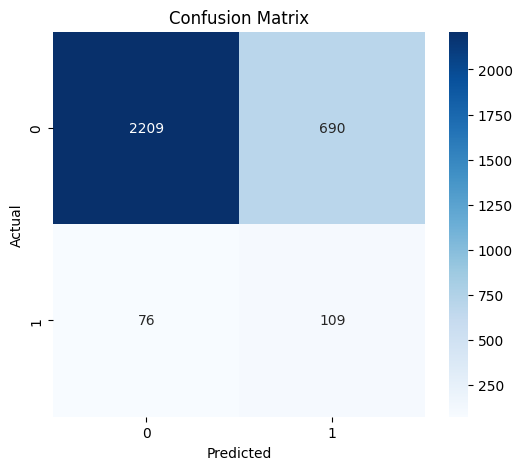

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_opt), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

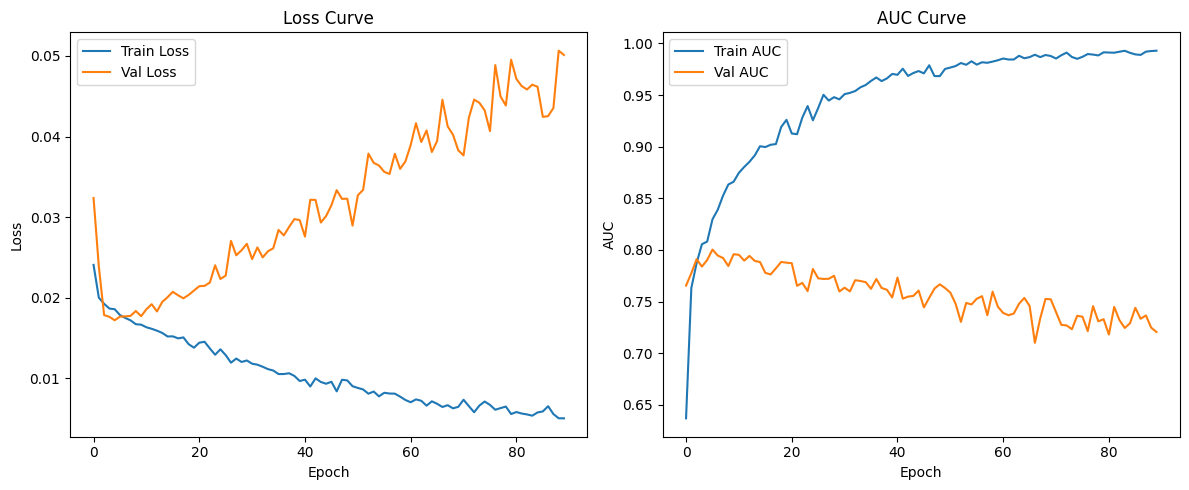

In [ ]:
# ---------------------------
# 6. Plot Training Curves
# ---------------------------

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC Curve')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()